## Hoori Javadnia
## ADS 509 Sentiment Assignment


This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.

In [ ]:
## Libraries we need

In [ ]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
punct = list(set(punctuation))
punct.append(",")
punct = "".join(punct)
tw_punct = list(set(punct) - set(["#"]))
tw_punct = "".join(tw_punct)

# Data Input
Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.



In [12]:
# Sentiment Text Files
positive_words_file = "/Users/javadniahoori/Downloads/509/6/assignment/positive-words.txt"
negative_words_file = "/Users/javadniahoori/Downloads/509/6/assignment/negative-words.txt"
tidy_text_file = "/Users/javadniahoori/Downloads/509/6/assignment/tidytext_sentiments.txt"

In [6]:

# Convert lyric text file to dataframe




def txt_to_dict(artist):
    # Create list of files in artist's subdirectory
    song_list = os.listdir(lyrics_path + artist)
    # Create empty list to hold data
    lyrics_list = []
    # Read each file in the artist's folder
    for song in song_list:
        metadata = {}
        path_to_song = lyrics_path + artist + "/" + song
        with open(path_to_song, "r") as song_lyrics:
            lyrics = song_lyrics.read()
        metadata["Artist"] = artist
        metadata["Title"] = lyrics.split("\n", 2)[0]
        metadata["Lyrics"] = lyrics.split("\n", 2)[2]
        # Append metadata to lyrics_list
        lyrics_list.append(metadata)
    # Convert lyrics_list to dict
    lyrics_df = pd.DataFrame.from_records(lyrics_list)
    
    return lyrics_df

In [8]:
# Read in the lyrics 

data_location = ("/Users/javadniahoori/Downloads/509/6/assignment/M1 Results/")
lyrics_folder = "lyrics/"
# Read in the lyrics data
lyrics_path = (data_location + lyrics_folder)
# Ingest lyrics to dataframe
# Columns: Artist, Title, Lyrics
cher_lyrics = txt_to_dict("cher")
robyn_lyrics = txt_to_dict("robyn")

In [10]:
# Read in the twitter data

cher_tweet_df = pd.read_table(
    "/Users/javadniahoori/Downloads/509/6/assignment/M1 Results/twitter/cher_followers_data.txt",
    delimiter = "\t",
    # Skips 17/3,000,000+ lines
    on_bad_lines = "skip")

robyn_tweet_df = pd.read_table(
    "/Users/javadniahoori/Downloads/509/6/assignment/M1 Results/twitter/robynkonichiwa_followers_data.txt",
    delimiter = "\t")

cher_tweet_df = cher_tweet_df.drop(cher_tweet_df.columns[0:-1], axis = 1)
robyn_tweet_df = robyn_tweet_df.drop(robyn_tweet_df.columns[0:-1], axis = 1)

In [13]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Read in Positive Words
pos_words_df = pd.read_csv(
    positive_words_file,
    delimiter = "\t",
    header = None,
    skiprows = 34)
# Rename Header Col.
pos_words_df.columns = ["word"]
# Add Sentiment Col.
pos_words_df["sentiment"] = "positive"

# Read in Negative Words
neg_words_df = pd.read_csv(
    negative_words_file,
    delimiter = "\t",
    header = None,
    skiprows = 34
)
# Rename Header Col.
neg_words_df.columns = ["word"]
# Add Sentiment Col.
neg_words_df["sentiment"] = "negative"

# Read in Tidytext Sentiment
tidytext_sent_df = pd.read_csv(
    tidy_text_file,
    delimiter = "\t"
)


all_sent_df = pd.concat(
    [
        pos_words_df[["word", "sentiment"]],
        neg_words_df[["word", "sentiment"]],
        tidytext_sent_df[["word", "sentiment"]]
    ],
    ignore_index = True# Merge all dataframes
)
all_sent_df = all_sent_df.drop_duplicates(subset = ["word"])# Drop duplicates

# Map sentiment to score values
# positive : 1, negative : -1
all_sent_df["score"] = all_sent_df["sentiment"].map({"positive" : 1, "negative" : -1})
sent_dict = dict(zip(all_sent_df["word"], all_sent_df["score"]))# Convert to dict

# Sentiment Analysis on Songs
In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.

In [14]:
#preprocess and tokenizing ()function)
def preproc_and_token(text):
    # Standardize casing
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", tw_punct))
    # Remove whitespaces
    whitespace_pattern = re.compile(r"\s+")
    text = whitespace_pattern.sub(r" ", text)
    # Split on spaces
    tokens = text.split(" ")
    tokens = [x for x in tokens if x != ""]
    # Remove stopwords
    tokens = [x for x in tokens if x not in sw]
    
    return tokens

In [15]:
cher_lyrics["Tokens"] = cher_lyrics["Lyrics"].apply(preproc_and_token)
robyn_lyrics["Tokens"] = robyn_lyrics["Lyrics"].apply(preproc_and_token)

In [16]:
# Sentiment Score
def sent_score(tokens, norm = False):
    score = 0
    for word in tokens:
        try:
            word_score = sent_dict[word]
            score += word_score
        except:
            pass
        
    if norm == True:
        # normalize for length of text
        score = score/len(tokens)
    return score

In [17]:
cher_lyrics["Sentiment_Score"] = cher_lyrics["Tokens"].apply(sent_score)
robyn_lyrics["Sentiment_Score"] = robyn_lyrics["Tokens"].apply(sent_score)

# normalized scores
cher_lyrics["Sentiment_Score_Normalized"] = cher_lyrics["Tokens"].apply(
    lambda x: sent_score(x, norm = True)
)
robyn_lyrics["Sentiment_Score_Normalized"] = robyn_lyrics["Tokens"].apply(
    lambda x: sent_score(x, norm = True)
)

In [18]:
#  avrage Sentiment per song
cher_avg_score = cher_lyrics["Sentiment_Score"].mean()
robyn_avg_score = robyn_lyrics["Sentiment_Score"].mean()

print("Cher's Average Sentiment Score: {}".format(cher_avg_score))
print("Robyn's Average Sentiment Score: {}".format(robyn_avg_score))

print("\n\nCher's Normalized Average Sentiment Score: " + 
      str(cher_lyrics["Sentiment_Score_Normalized"].mean()))
print("Robyn's Normalized Average Sentiment Score: " + 
      str(robyn_lyrics["Sentiment_Score_Normalized"].mean()))

Cher's Average Sentiment Score: 5.699367088607595
Robyn's Average Sentiment Score: 8.39423076923077


Cher's Normalized Average Sentiment Score: 0.05044757338054811
Robyn's Normalized Average Sentiment Score: 0.06272452111496819


In [19]:
# Cher's Top 3 Sentiment Songs
cher_lyrics.sort_values(
    "Sentiment_Score_Normalized", ascending = False).head(3)[
        ["Title", "Lyrics", "Sentiment_Score_Normalized"]]

,Title,Lyrics,Sentiment_Score_Normalized
15,"""My Love""",\n\nWhen I go away\nI know my heart can stay w...,0.524390
85,"""Sunny""","\n\nSunny, yesterday my life was filled with r...",0.455696
146,"""Love And Understanding""","\n\nHere, here in this world\nWhere do we go? ...",0.381579


In [20]:
print(cher_lyrics.loc[181, "Lyrics"])
print(cher_lyrics.loc[237, "Lyrics"])
print(cher_lyrics.loc[155, "Lyrics"])



Love is a lonely place without you

I know I'm not alone
I should not be afraid
Cause I hear your voice
And I know you're there beside me

And so I give my heart
I live to love again
But I can't let go
Of the way I feel about you

Love is a lonely place without you
I miss you
And you're almost here
And I'm almost touching you
Love is a place I have to hide away

I'll never love this way again (again)

If love was ever true
I know it was with you
Cause you touch my soul and 
You stay with me forever

No tears, no said goodbyes
There are no reasons why
But I'm holding on 
I believe in love eternal

Love is a lonely place without you
I miss you
And you're almost here
And I'm almost touching you
Love is a place I have to hide away
I'll never love this way again (again)

Though I'm moving on
I'm still holding on - holding on - holding on

Love is a lonely place without you
I miss you
And you're almost here
And I'm almost touching you
Love is a place I have to hide away
I'll never love thi

In [21]:
# Cher's Bottom 3 Sentiment Songs
cher_lyrics.sort_values(
    "Sentiment_Score_Normalized", ascending = True).head(3)[
        ["Title", "Lyrics", "Sentiment_Score_Normalized"]]

,Title,Lyrics,Sentiment_Score_Normalized
41,"""Bang-Bang""",\n\nBang bang you shot me down\nBang bang I hi...,-0.410405
195,"""Bang Bang (My Baby Shot Me Down)""",\n\nI was five and he was six\nWe rode on hors...,-0.343750
240,"""Cry Myself To Sleep""","\n\nEvery night, I lay my head\nOn my pillow o...",-0.250000


In [22]:
print(cher_lyrics.loc[16, "Lyrics"])
print(cher_lyrics.loc[17, "Lyrics"])
print(cher_lyrics.loc[42, "Lyrics"])



You're not a dream, you're not an angel
You're a man
I'm not a queen, I'm a woman
Take my hand
We'll make a space in the lives
That we'd planned
And here we'll stay
Until it's time for you to go

Yes, we're different worlds apart
We're not the same
We laughed and played at the start
Like in a game
You could have stayed outside my heart
But in you came
And here you'll stay
Until it's time for you to go

Don't ask why of me
Don't ask how
Don't ask forever
Love me, love me now

This love of mine had no beginning
It has no end
I was an oak, now I'm a willow
I can bend
And though I'll never in my life
See you again
Still, I'll stay
Until it's time for you to go



It ain't no use to sit and wonder why, baby
If'n you don't know by now
It ain't no use to sit and wonder why, baby
If'n you don't know by now
When your rooster crows at the break of dawn
Look out your window, and I'll be gone
You're the reason I'm a-travelin on
But don't think twice, it's all right

Ain't no use in turning on yo

In [23]:
# Robyn's Top 3 Sentiment Songs
robyn_lyrics.sort_values(
    "Sentiment_Score_Normalized", ascending = False).head(3)[
        ["Title", "Lyrics", "Sentiment_Score_Normalized"]]

,Title,Lyrics,Sentiment_Score_Normalized
64,"""Baby Forgive Me""","\n\nHere come the night\nIn your eyes\nBaby, b...",0.520000
21,"""Love Is Free""","\n\nFree\nLove is free, baby\nFree\nLove is fr...",0.399361
49,"""Between The Lines""",\n\nEven reading in between the lines\n\nEvery...,0.315152


In [24]:
print(robyn_lyrics.loc[3, "Lyrics"])
print(robyn_lyrics.loc[64, "Lyrics"])
print(robyn_lyrics.loc[7, "Lyrics"])



If you're looking for love
Get a heart made of steel 'cus you know that love kills
Don't go messing with love
It'll hurt you for real, don't you know that love kills

If you're looking for love
Get a heart made of steel 'cus you know that love kills
Don't go messing with love
It'll hurt you for real, don't you know that love kills

Protect yourself, 'cus you'll wreck yourself
In this cold, hard world, so check yourself
You conceal your dreams and you shield yourself
'Til that one kind soul reveals itself

Protect yourself, 'cus you'll wreck yourself
In this cold, hard world, so check yourself
You conceal your dreams and you shield yourself
'Til that one kind soul reveals itself

If you're looking for love
Get a heart made of steel 'cus you know that love kills
Don't go messing with love
It'll hurt you for real, don't you know that love kills

If you're looking for love
Get a heart made of steel 'cus you know that love kills
Don't go messing with love
It'll hurt you for real, don't yo

In [25]:
# Robyn's Bottom 3 Sentiment Songs
robyn_lyrics.sort_values(
    "Sentiment_Score_Normalized", ascending = True).head(4)[
        ["Title", "Lyrics", "Sentiment_Score_Normalized"]]

,Title,Lyrics,Sentiment_Score_Normalized
75,"""Don't Fucking Tell Me What To Do""",\n\nMy drinking is killing me\nMy drinking is ...,-0.517241
53,"""Don't Fucking Tell Me What To Do""",\n\nMy drinking is killing me\nMy drinking is ...,-0.517241
16,"""Criminal Intent""","\n\nSomebody alert the authorities, I got crim...",-0.181495
93,"""Robotboy""","\n\nHey now boy, where you been?\nSmashed up t...",-0.137255


In [26]:
print(robyn_lyrics.loc[27, "Lyrics"])
print(robyn_lyrics.loc[18, "Lyrics"])
print(robyn_lyrics.loc[80, "Lyrics"])



It's all over like steps in the first snow
Something's been building up and it's gonna blow
My momma called me last night, she said what nothing else fits
Pick up the pieces and move on
I see the flashing lights, just can't make sense of the bits 
It's like my mind is gone

I got ... got to get ...
Get my head back on
I got ... got to get ...
Myself together
When this hurt is gone
I got ... got to get ...
Myself together

I got ... got to get ...
Can't tell what's going wrong
I wish there's something could be done
Knock that cover
When this hurt is gone
I got ... got to get ...
Myself together

Can't stand to see you upset
But you already know
The more close it gets
The less I wanna go

I saw my brother last night
He said I know you too well
You can't pretend that's nothing wrong
I see the fuse that ignites, like I'm outside of myself
It's like my mind is gone

I got ... got to get ...
Get my head back on
I got ... got to get ...
Myself together
When this hurt is gone
I got ... got t

# Questions



Q: Overall, which artist has the higher average sentiment per song?

A: Cher's average sentiment score was 5.69, 
Robyn's was approximately 8.4. Robyn had a higher average sentiment score per song.



Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: Cher's top three songs with high sentiment scores are : 
My Love, Sunny, and Love and Understanding.the lowest three songs are Bang-Bang, Bang Bang (My Baby Shot Me Down), and Cry Myself to Sleep, exhibiting lower sentiment scores due to negative word usage.




Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: Robyn's top three songs are :
Baby Forgive Me, Love is Free, and Between The Lines, with high sentiment scores.Her lowest three songs—Don't Fucking Tell Me What To Do, Criminal Intent, and Robotboy—have lower sentiment scores due to their negative themes and word usage.

In [38]:
cher_lyrics["Sentiment_Score"]

0      -1
1       8
2       8
3      -4
4      12
       ..
311     9
312    25
313    -3
314     9
315     3
Name: Sentiment_Score, Length: 316, dtype: int64

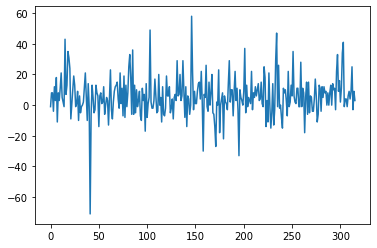

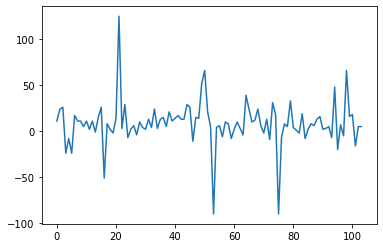

In [44]:
plt.plot(cher_lyrics["Sentiment_Score"], label = "Cher")
plt.figure()
plt.plot(robyn_lyrics["Sentiment_Score"], label = "Robyn")



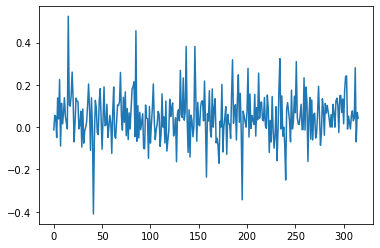

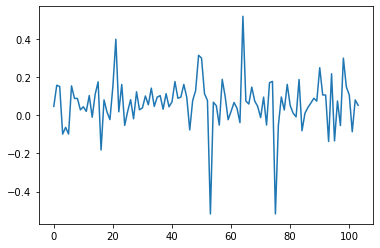

In [43]:
plt.plot(cher_lyrics["Sentiment_Score_Normalized"],
             label = "Cher")
plt.figure()
plt.plot(robyn_lyrics["Sentiment_Score_Normalized"],
             label = "Robyn")



# Sentiment Analysis on Twitter Descriptions
In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at the emojitracker.

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [29]:
pos_emoji_dict = {u'😂': 1,
 u'❤': 1,  u'😍': 1,  u'😀': 1,
 u'😃': 1,  u'😄': 1,  u'😁': 1,
 u'😆': 1,  u'😅': 1,  u'🤣': 1,
 u'🙂': 1,  u'😉': 1,  u'😊': 1,
 u'🥰': 1,  u'🤩': 1,  u'😘': 1,
 u'🧡': 1,  u'💛': 1,  u'💚': 1,
 u'💙': 1,  u'💜': 1,  u'🤎': 1,
 u'💕': 1,  u'💞': 1,  u'💖': 1,
 u'💘': 1,  u'💗': 1,  u'💓': 1,
 u'💝': 1,  u'👍': 1,  u'🎉': 1,
 u'✨': 1,  u'🎊': 1,  u'🙌': 1}

neg_emoji_dict = {u'☹️': -1,
 u'🙃': -1,  u'😒': -1,  u'😔': -1,
 u'😕': -1,  u'😟': -1,  u'🙁': -1,
 u'🤢': -1,  u'🤮': -1,  u'🤕': -1,
 u'😧': -1,  u'😨': -1,  u'😰': -1,
 u'😥': -1,  u'😢': -1,  u'😭': -1,
 u'😱': -1,  u'😖': -1,  u'😣': -1,
 u'😞': -1,  u'😓': -1,  u'😩': -1,
 u'😫': -1,  u'😤': -1,  u'😡': -1,
 u'😠': -1,  u'🤬': -1,  u'💔': -1,
 u'👎': -1}

# Combine Dict
all_emoji_dict = pos_emoji_dict | neg_emoji_dict

In [30]:
def emoji_score(text, norm = False):
    text = str(text)
    score = 0
    num_emojis = 0
    for char in text:
        try:
            emoji_val = all_emoji_dict[char]
            score += emoji_val
            num_emojis += 1
        except:
            pass

    if norm == True:
        try:
            # Normalize for total number of emojis
            score = score/num_emojis
        except:
            # Handle div by zero
            score = 0
    
    return score

In [31]:
# Remove missing values
cher_tweet_df = cher_tweet_df.dropna()
robyn_tweet_df = robyn_tweet_df.dropna()

In [32]:
cher_tweet_df["Emoji_Score"] = cher_tweet_df["description"].apply(emoji_score)
robyn_tweet_df["Emoji_Score"] = robyn_tweet_df["description"].apply(emoji_score)

cher_tweet_df["Emoji_Score_Normalized"] = cher_tweet_df["description"].apply(
    emoji_score, norm = True)
robyn_tweet_df["Emoji_Score_Normalized"] = robyn_tweet_df["description"].apply(
    emoji_score, norm = True)

In [33]:
print("Cher's average emoji score: " + str(cher_tweet_df["Emoji_Score"].mean()))
print("Robyn's average emoji score: " + str(robyn_tweet_df["Emoji_Score"].mean()))

print("\n\nCher's average emoji score: " + 
      str(cher_tweet_df["Emoji_Score_Normalized"].mean()))
print("Robyn's average emoji score: " + 
      str(robyn_tweet_df["Emoji_Score_Normalized"].mean()))

Cher's average emoji score: 0.12226649022873917
Robyn's average emoji score: 0.06711158169431343


Cher's average emoji score: 0.06921188648037598
Robyn's average emoji score: 0.040006243380132915


In [34]:
# Count Every Character
cher_char_counter = Counter(text for word in cher_tweet_df["description"] for text in word)
robyn_char_counter = Counter(text for word in robyn_tweet_df["description"] for text in word)

In [35]:
# Count Positive/Negative Emojis
cher_pos_emoji_dict = {}
for key in pos_emoji_dict:
    try:
        emoji_value = cher_char_counter[key]
        cher_pos_emoji_dict[key] = emoji_value
    except:
        pass

cher_neg_emoji_dict = {}
for key in neg_emoji_dict:
    try:
        emoji_value = cher_char_counter[key]
        cher_neg_emoji_dict[key] = emoji_value
    except:
        pass

robyn_pos_emoji_dict = {}
for key in pos_emoji_dict:
    try:
        emoji_value = robyn_char_counter[key]
        robyn_pos_emoji_dict[key] = emoji_value
    except:
        pass

robyn_neg_emoji_dict = {}
for key in neg_emoji_dict:
    try:
        emoji_value = robyn_char_counter[key]
        robyn_neg_emoji_dict[key] = emoji_value
    except:
        pass

In [36]:
def top_emoji(emoji_dict):
    df = pd.DataFrame({"Emoji" : emoji_dict.keys(), "Count" : emoji_dict.values()})
    df = df.sort_values("Count", ascending = False)
    return df

print("Cher Top Positive Emoji")
print(top_emoji(cher_pos_emoji_dict).head(1))
print("Cher Top Negative Emoji")
print(top_emoji(cher_neg_emoji_dict).head(1))

print("Robyn Top Positive Emoji")
print(top_emoji(robyn_pos_emoji_dict).head(1))
print("Robyn Top Negative Emoji")
print(top_emoji(robyn_neg_emoji_dict).head(1))

Cher Top Positive Emoji
  Emoji  Count
1     ❤  79373
Cher Top Negative Emoji
   Emoji  Count
27     💔   1616
Robyn Top Positive Emoji
  Emoji  Count
1     ❤   4808
Robyn Top Negative Emoji
  Emoji  Count
1     🙃    128


Q: What is the average sentiment of your two artists?

A: 
Cher's average emoji score is 0.1222, Robyn's is 0.06. Normalized scores are 0.07 for Cher and 0.04 for Robyn.




Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A:Both liked the heart emoji, but Cher used the broken heart as her negative symbol while Robyn chose the upside-down smiley.